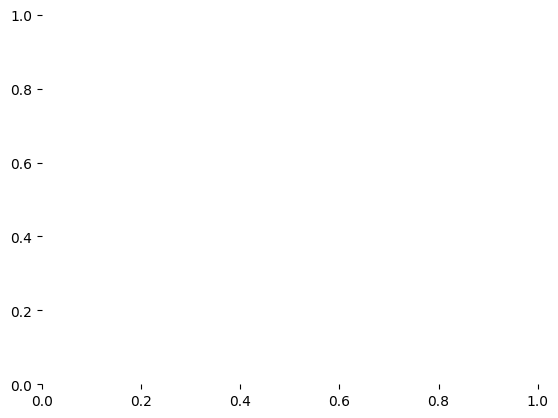

In [1]:
import os 
import torch 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
plt.box(False)

In [2]:
def applySHlight(normal_images, sh_coeff):
  N = normal_images
  sh = torch.stack(
    [
      N[0] * 0.0 + 1.0,
      N[0],
      N[1],
      N[2],
      N[0] * N[1],
      N[0] * N[2],
      N[1] * N[2],
      N[0] ** 2 - N[1] ** 2,
      3 * (N[2] ** 2) - 1,
    ],
    0,
  )  # [9, h, w]
  pi = np.pi
  constant_factor = torch.tensor(
    [
      1 / np.sqrt(4 * pi), #confirmed
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
      (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
    ]
  ).float()
  sh = sh * constant_factor[:, None, None]

  shading = torch.sum(
    sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
  )  # [9, 3, h, w]

  return shading


In [3]:
def genSurfaceNormals(n):
  x = torch.linspace(-1, 1, n)
  y = torch.linspace(1, -1, n)
  y, x = torch.meshgrid(y, x)

  z = (1 - x ** 2 - y ** 2)
  mask = z < 0
  z[mask] = 0
  z = torch.sqrt(z)
  return torch.stack([x, y, z], 0), mask

In [4]:
def applySHlightXYZ(xyz, sh):
  out = applySHlight(xyz, sh)
  return out
  #bar = torch.quantile(out, 0.99)
  #out = out / bar 
  # out /= pt.max(out)
  #out *= 0.7
  #return torch.clip(out, 0, 1)

In [5]:
def drawSphere(sh, img_size=256, is_back=False, white_bg=False):
  n = img_size
  xyz, mask = genSurfaceNormals(n)
  if(is_back):
    xyz[2] = xyz[2] * -1
  if white_bg:
    xyz[:, mask] = 1
  out = applySHlightXYZ(xyz, sh)
  out[:, xyz[2] == 0] = 0
  return out

In [6]:
def create_image_grid(images, rows, cols):
  """Creates an image grid of size rows x cols from a list of PIL.Images.

  Args:
      images: A list of PIL.Image objects.
      rows: The desired number of rows in the grid.
      cols: The desired number of columns in the grid.

  Returns:
      A new PIL.Image object containing the image grid.
  """
  if len(images) != rows * cols:
    raise ValueError(f"List must contain exactly {rows * cols} images for a {rows}x{cols} grid.")

  # Find the maximum width and height of the images
  max_width = max(image.size[0] for image in images)
  max_height = max(image.size[1] for image in images)

  # Calculate the total width and height of the grid
  grid_width = cols * max_width
  grid_height = rows * max_height

  # Create a new image for the grid
  grid_image = Image.new('RGB', size=(grid_width, grid_height))

  # Paste each image into the grid with padding
  for i, image in enumerate(images):
    row = i // cols
    col = i % cols
    x_offset = col * max_width
    y_offset = row * max_height

    # Paste the image with padding to center it within its grid cell
    paste_box = (x_offset + (max_width - image.size[0]) // 2,
                 y_offset + (max_height - image.size[1]) // 2,
                 x_offset + max_width,
                 y_offset + max_height)
    grid_image.paste(image, box=paste_box)

  return grid_image


In [7]:
DIRECTIONS = ['left','right', 'bottom', 'top', 'back', 'front']

DIRECTION: 
DIRECTION: 


/tmp/ipykernel_1057473/1552049388.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1, frameon=False, gridspec_kw={'wspace':0, 'hspace':0},squeeze=True)  # Create a figure and axes object


DIRECTION: 
DIRECTION: 
DIRECTION: 
DIRECTION: 


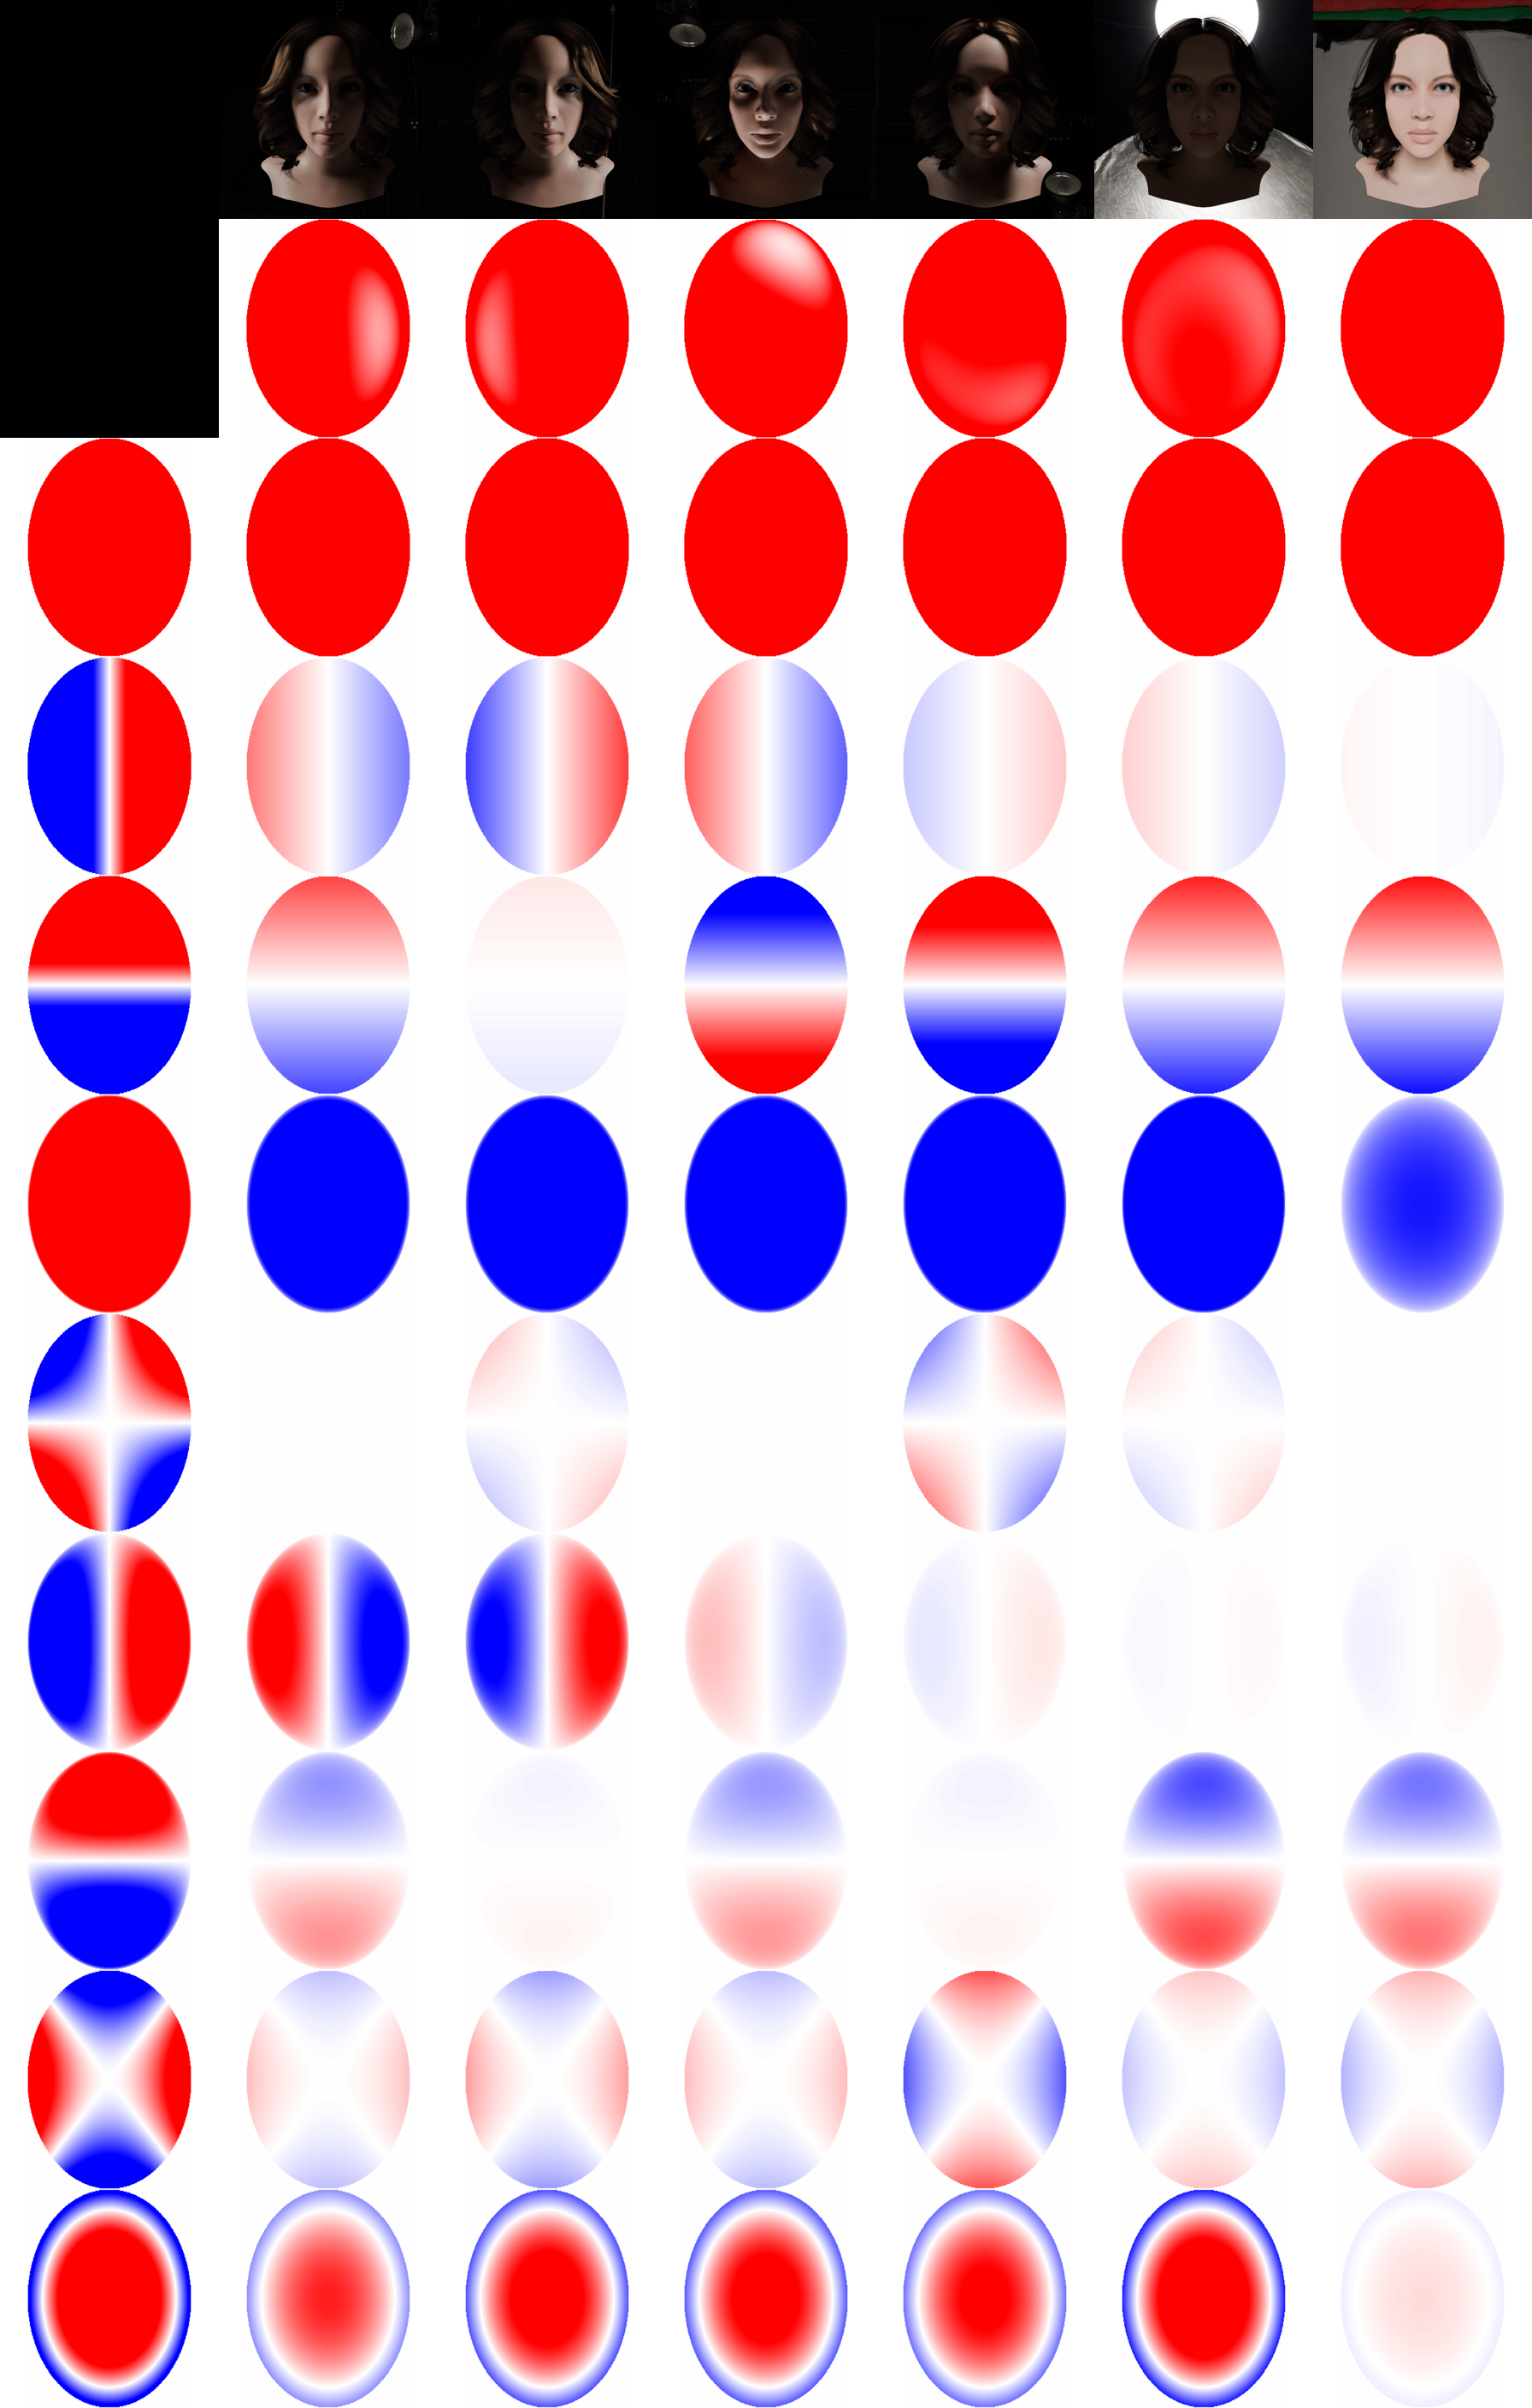

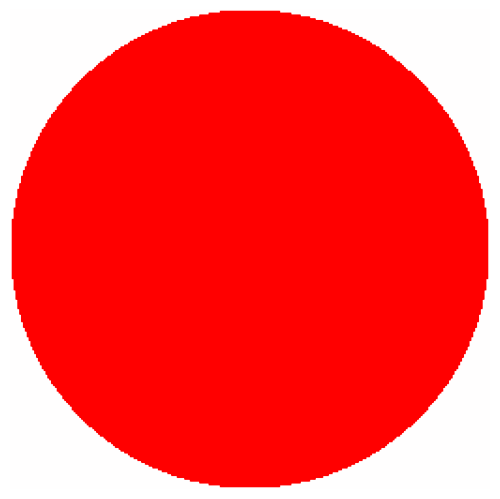

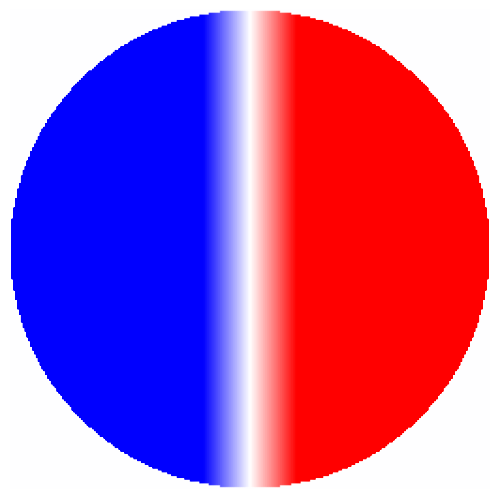

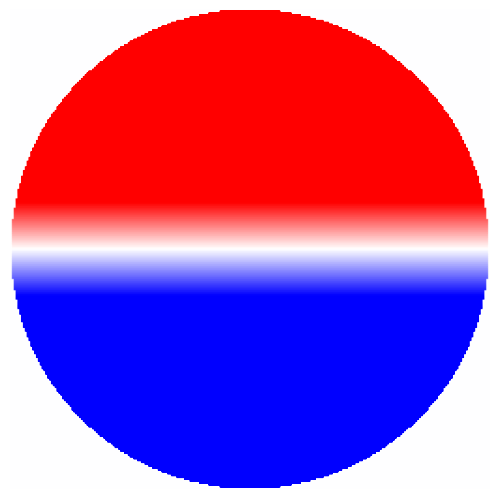

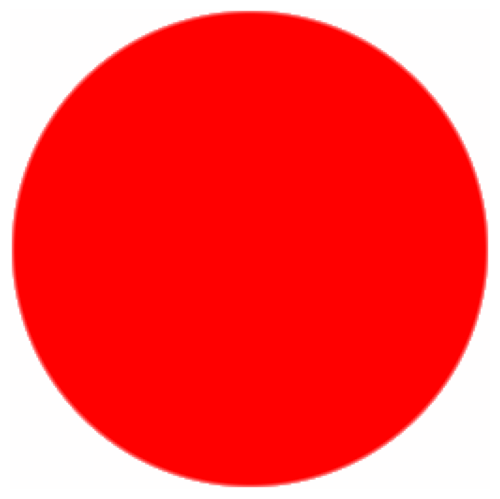

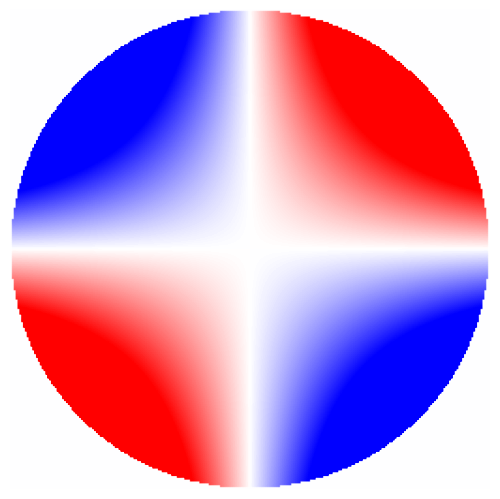

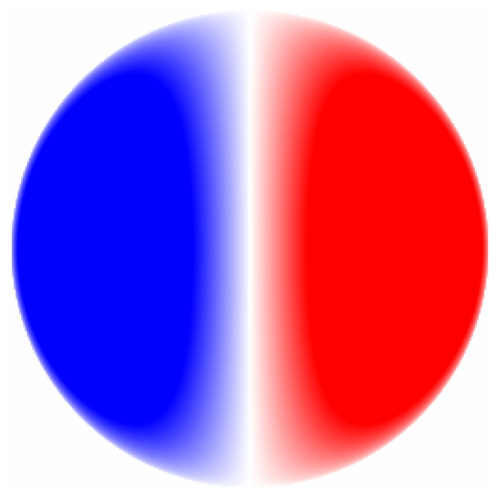

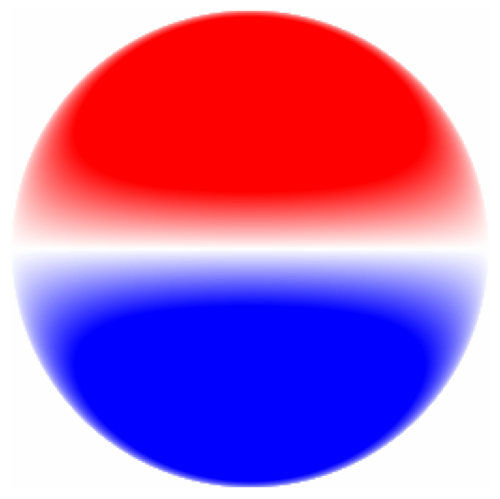

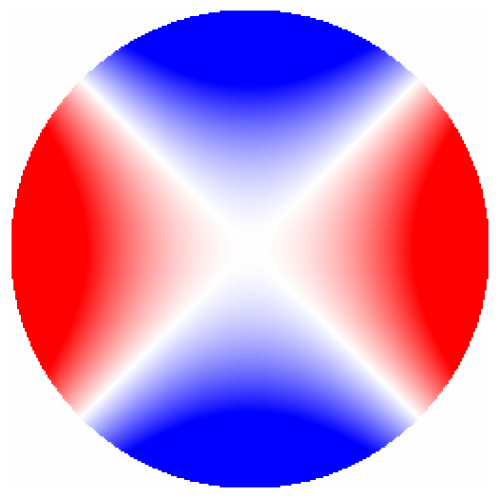

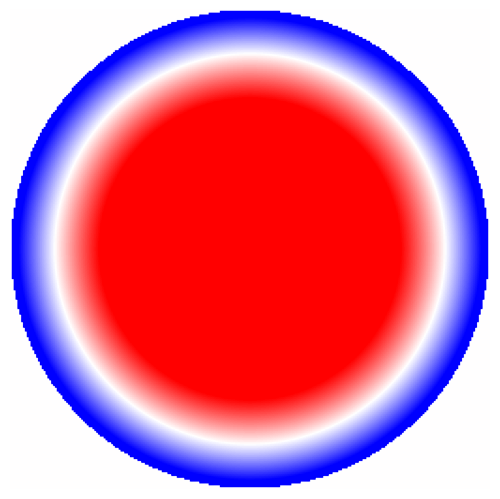

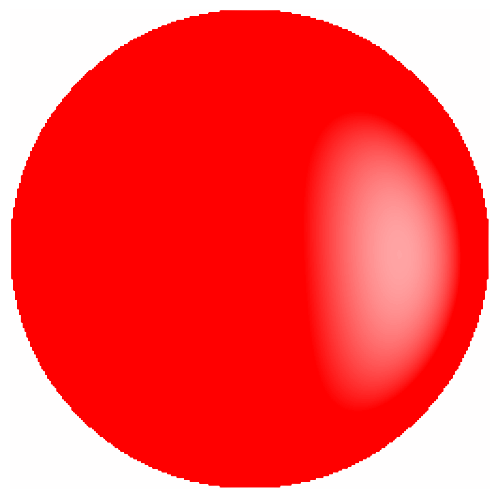

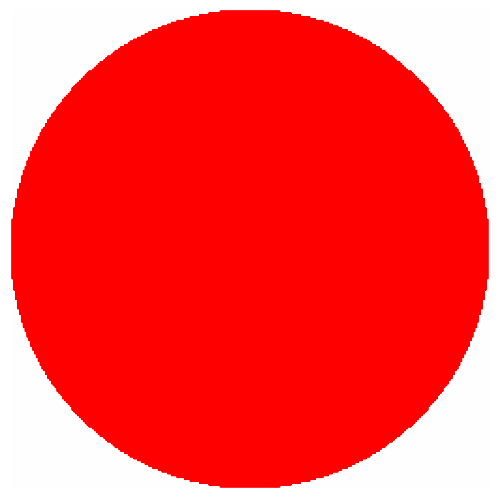

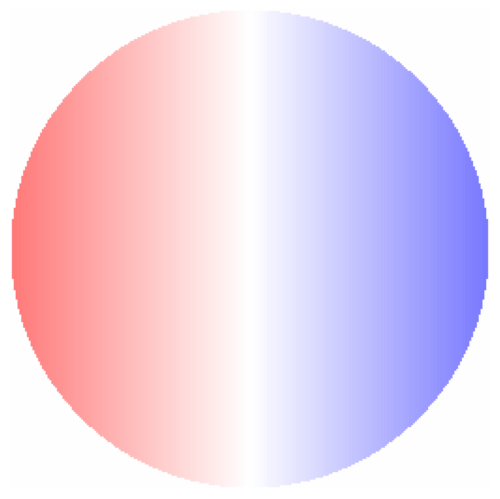

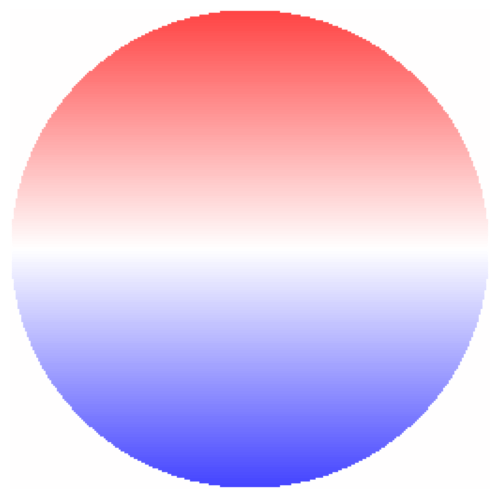

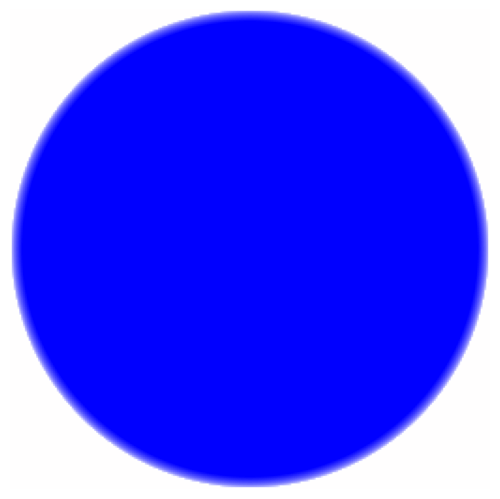

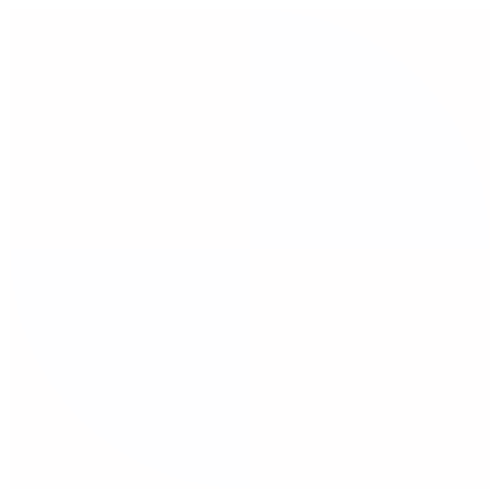

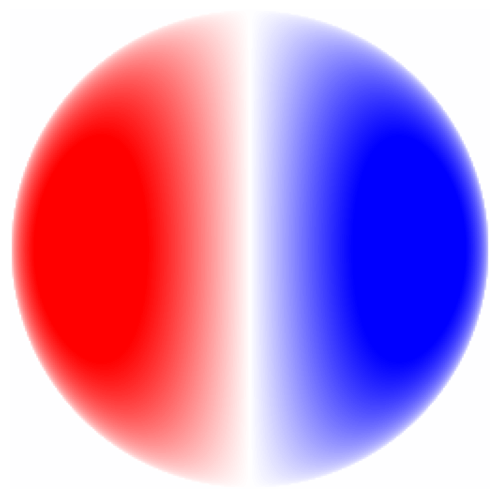

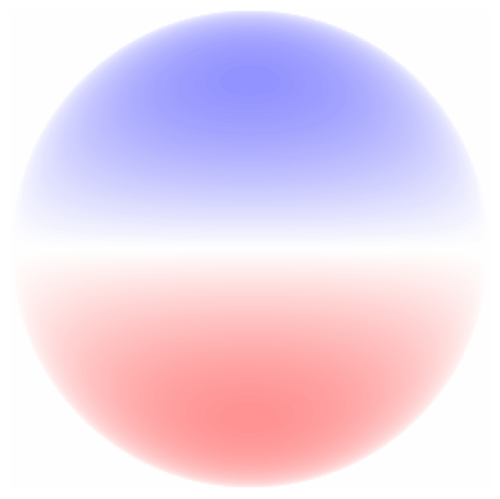

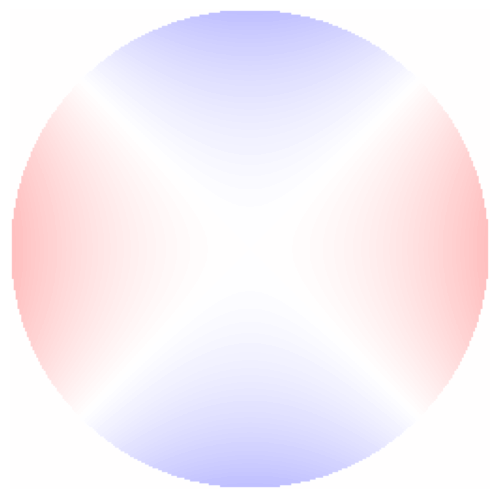

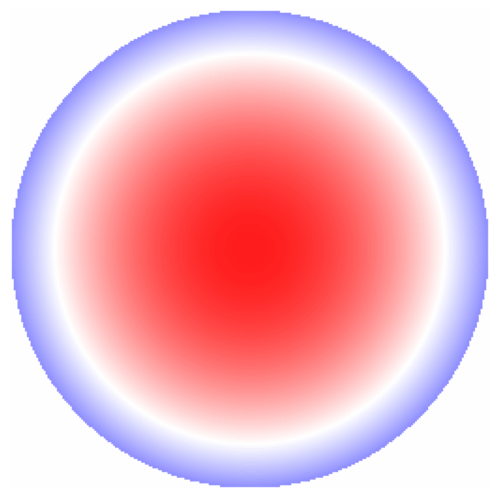

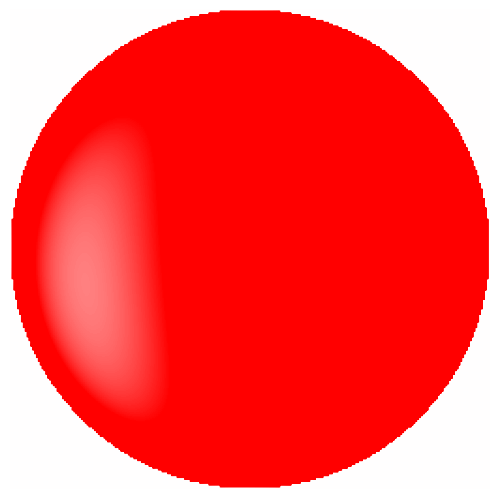

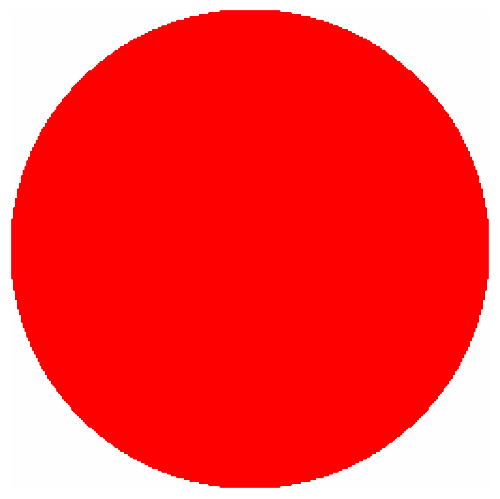

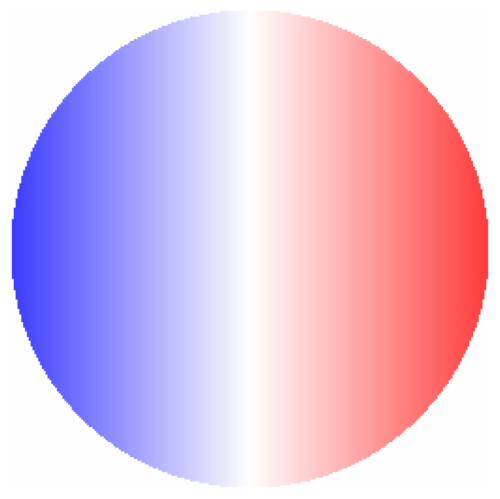

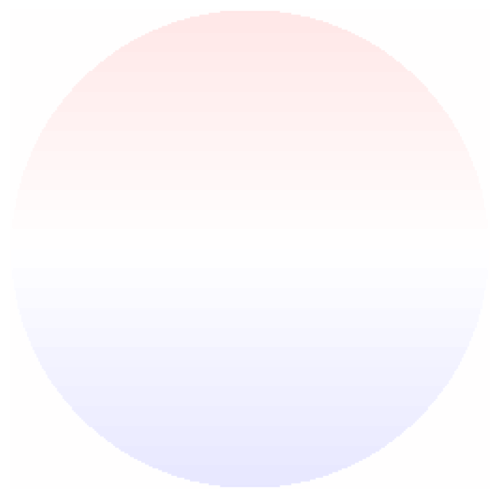

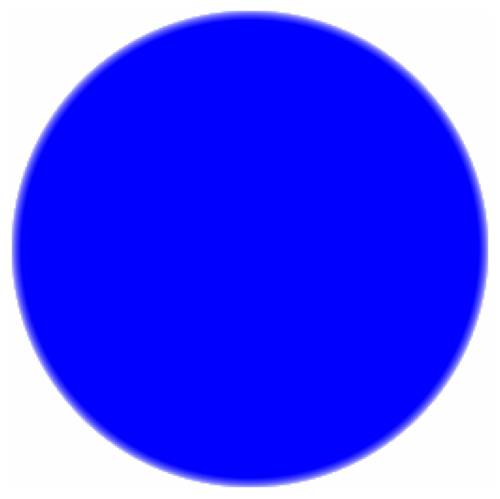

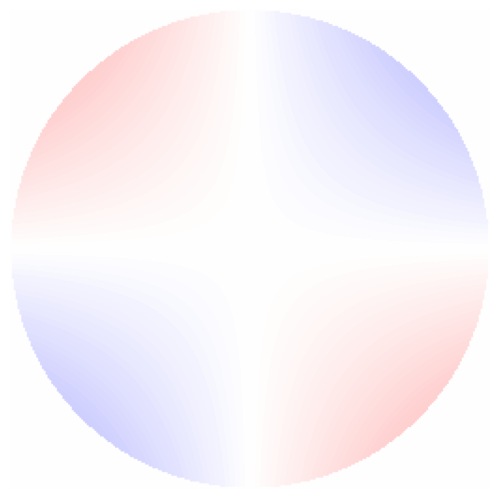

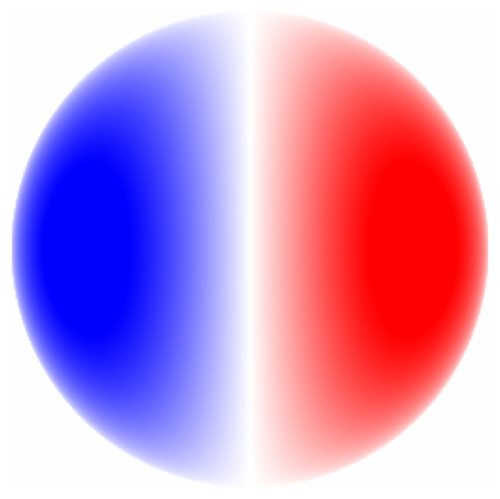

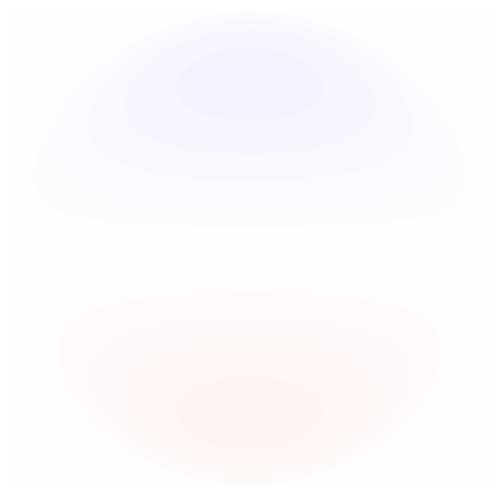

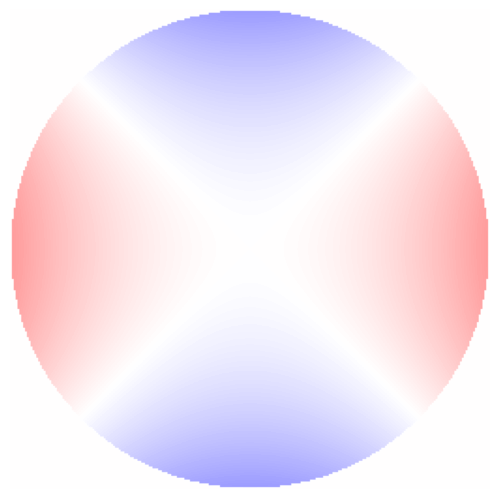

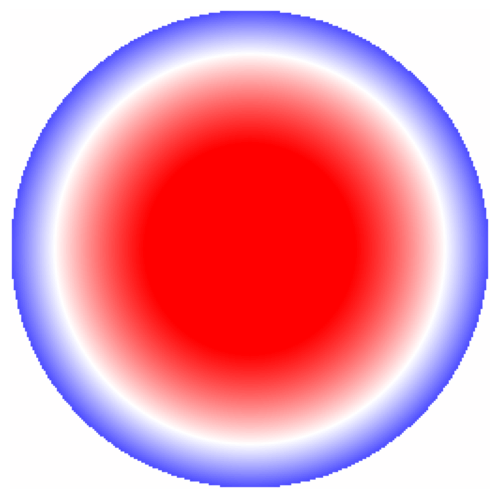

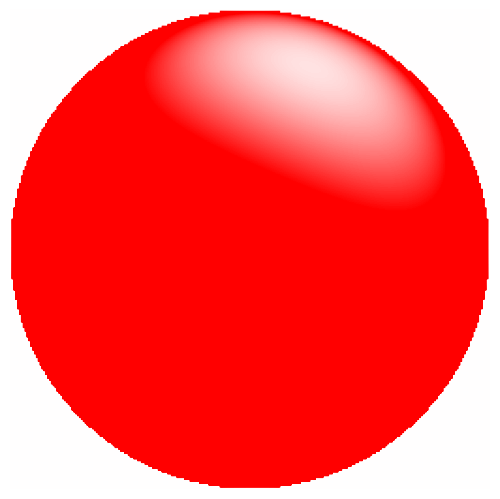

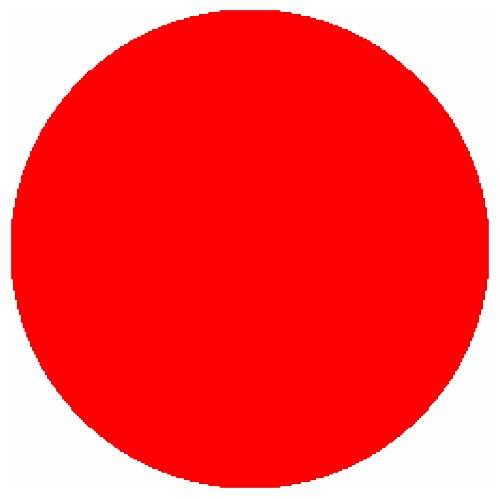

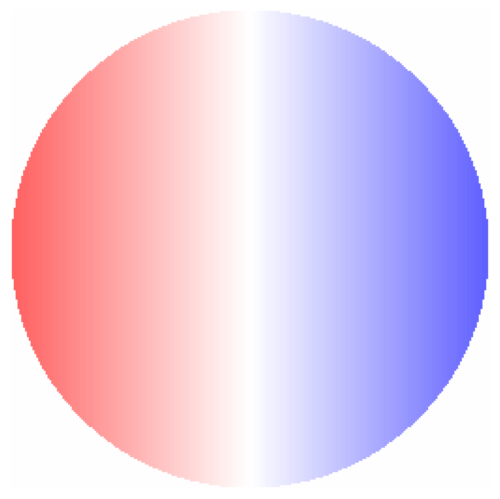

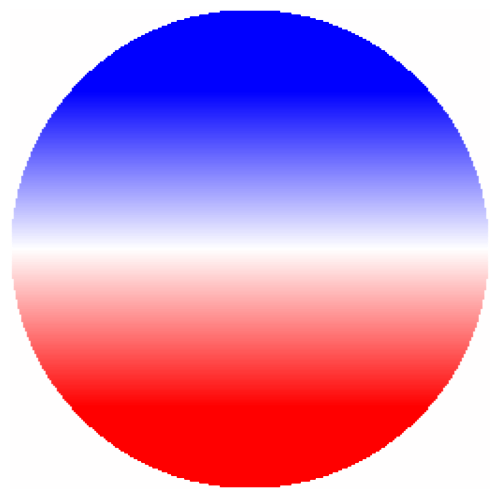

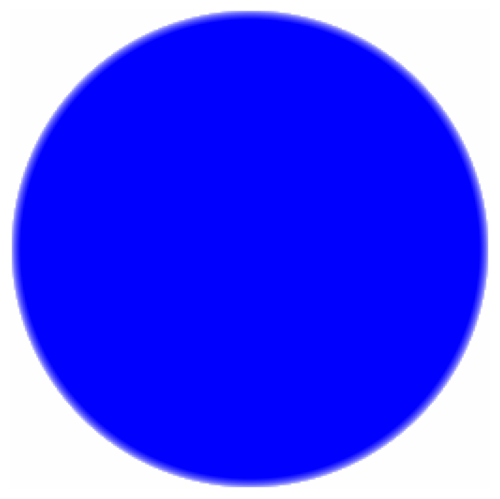

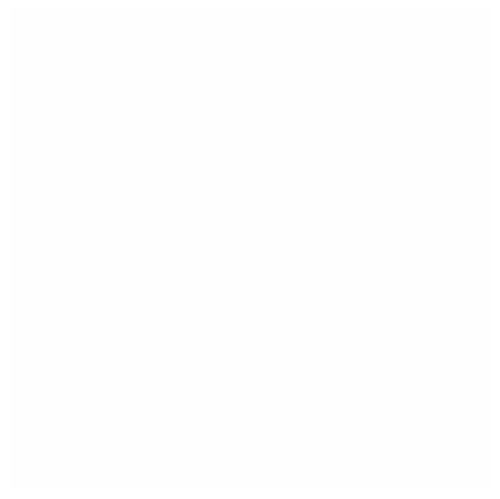

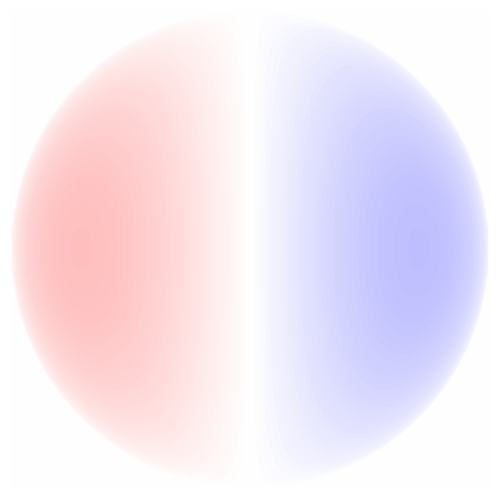

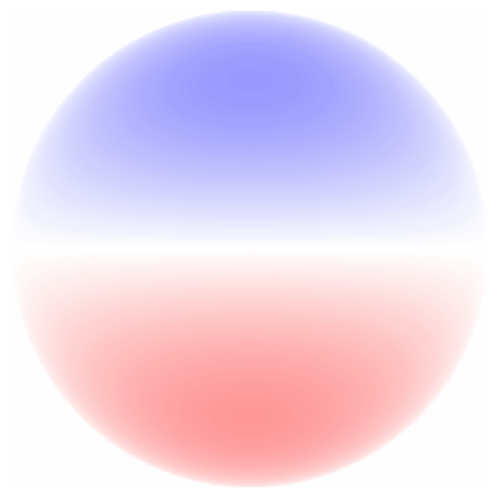

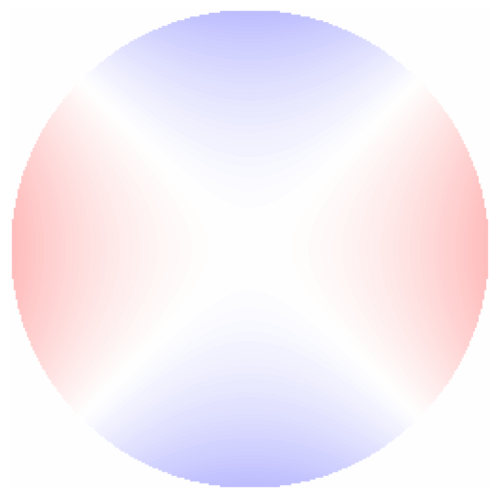

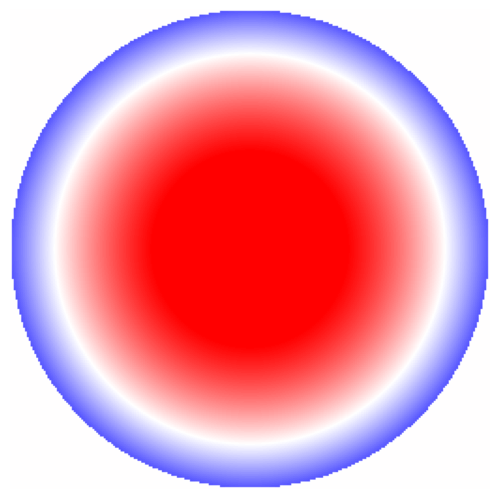

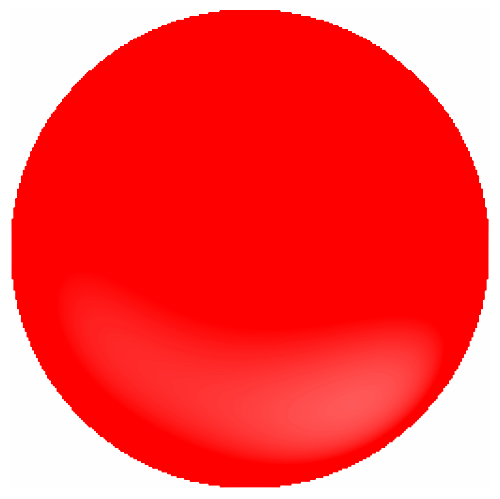

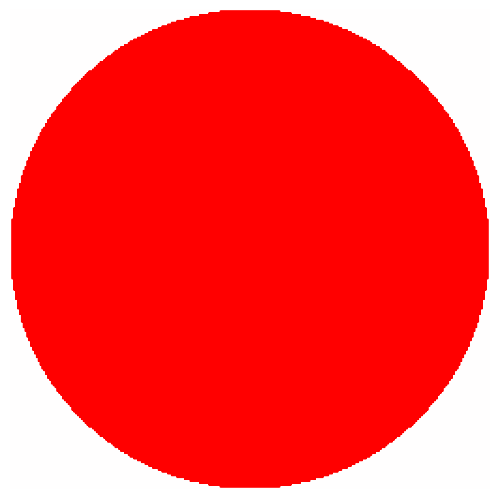

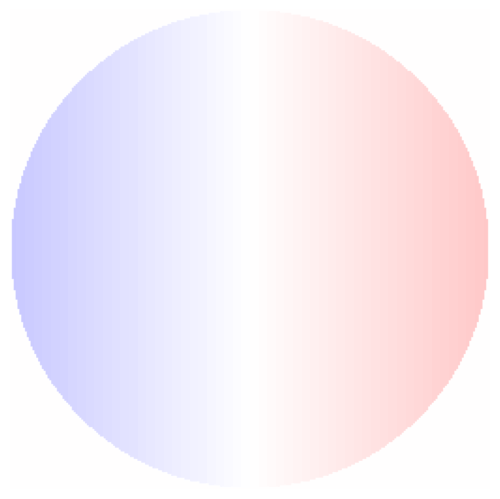

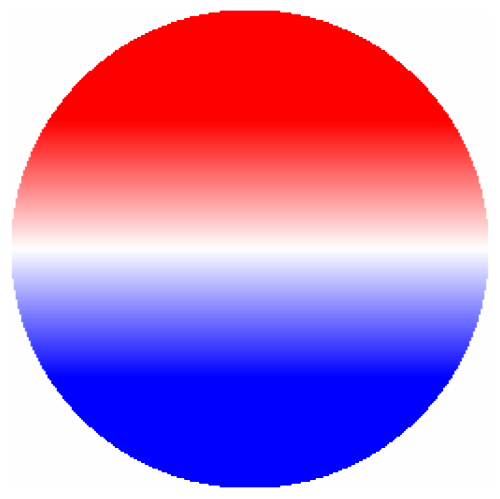

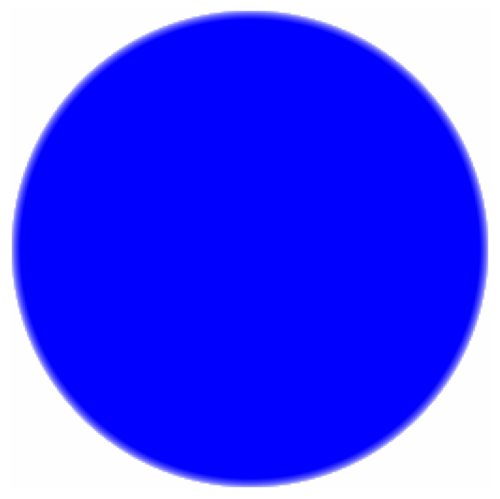

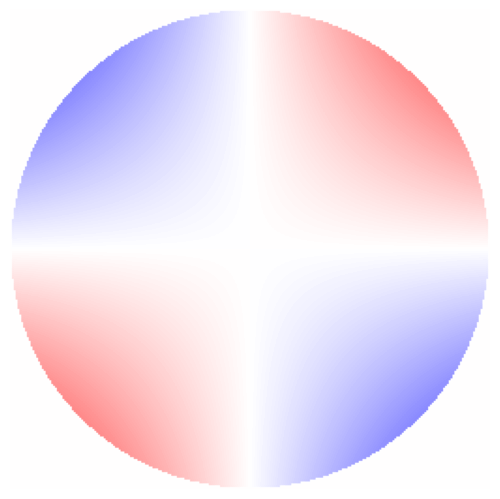

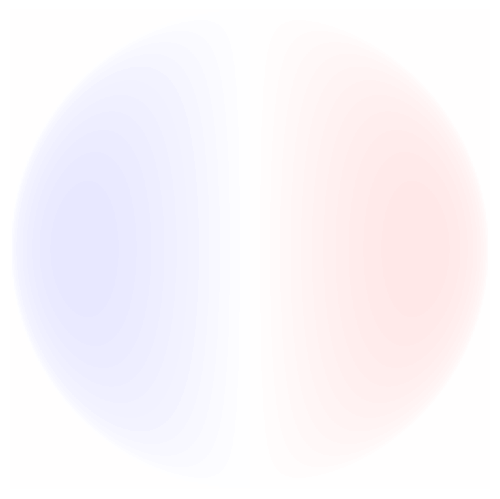

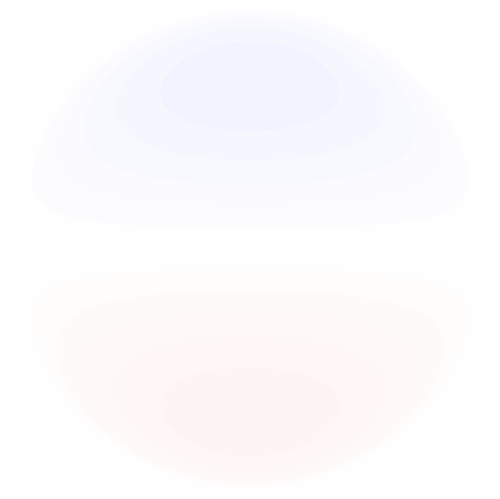

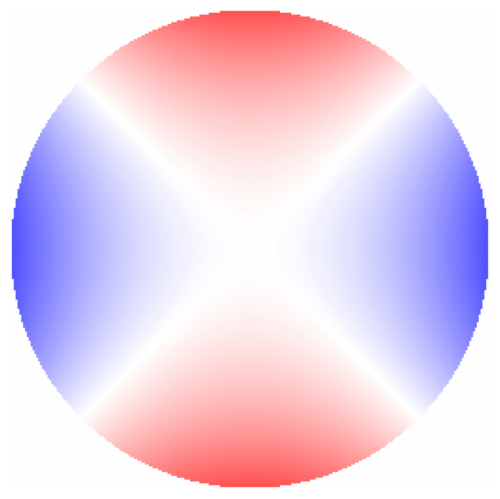

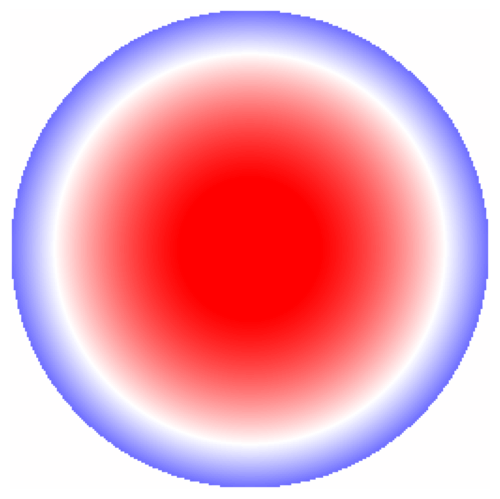

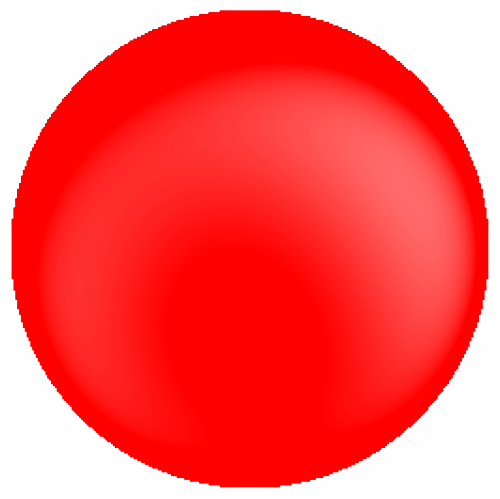

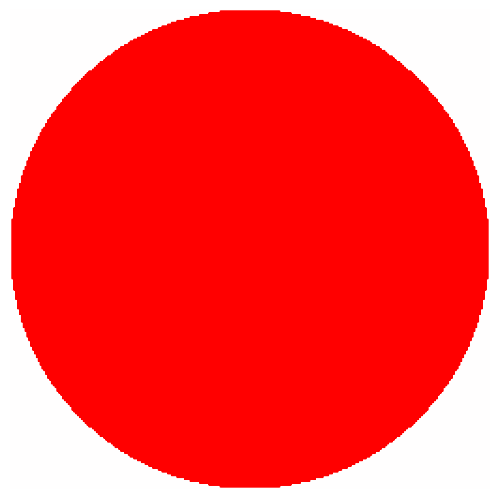

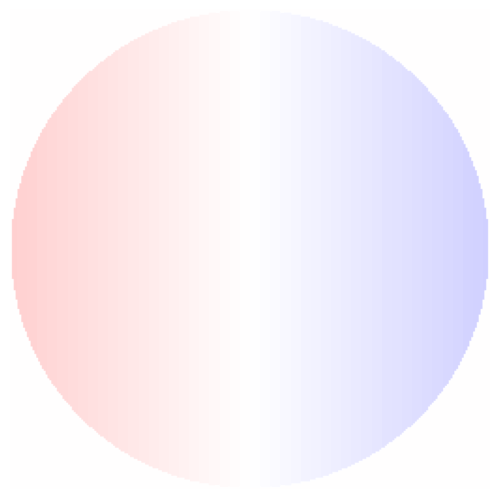

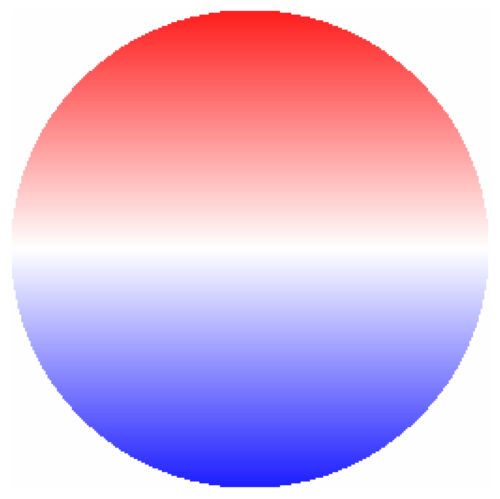

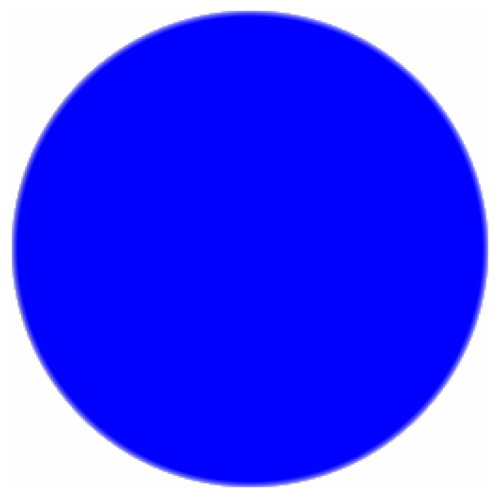

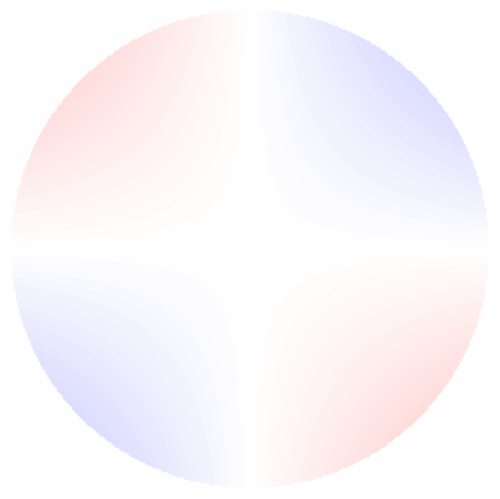

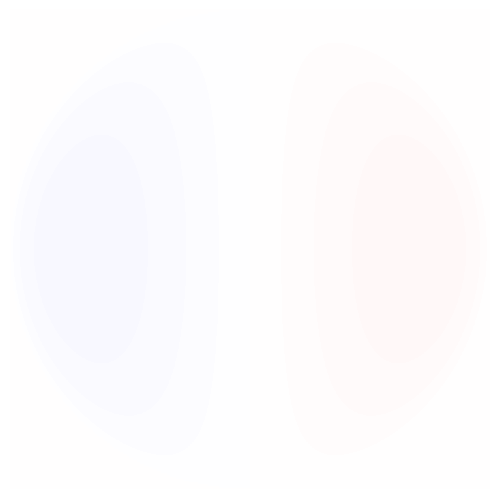

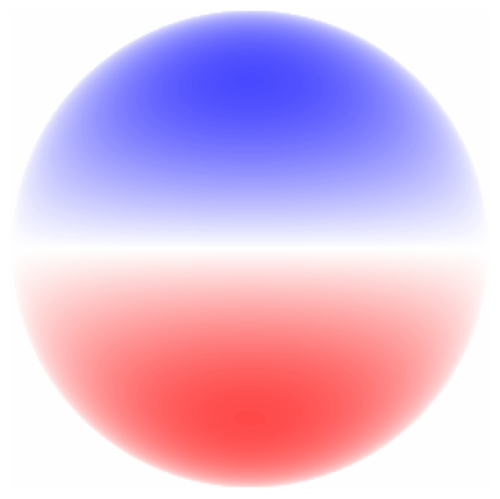

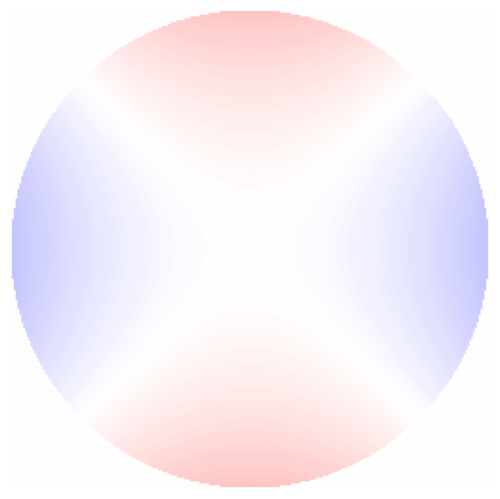

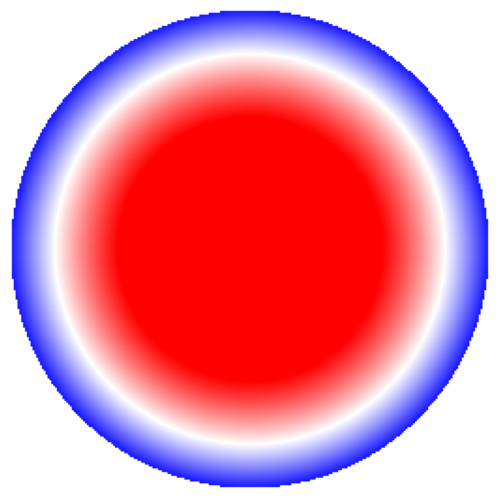

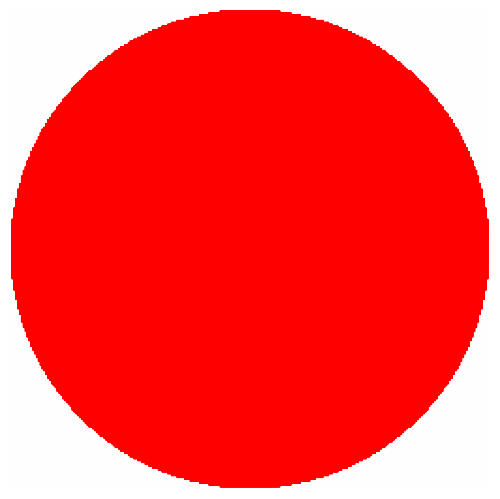

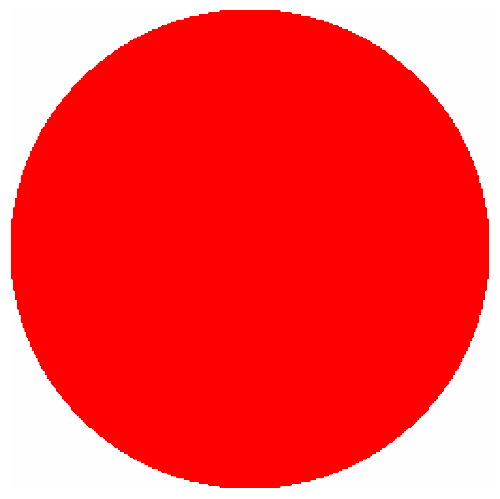

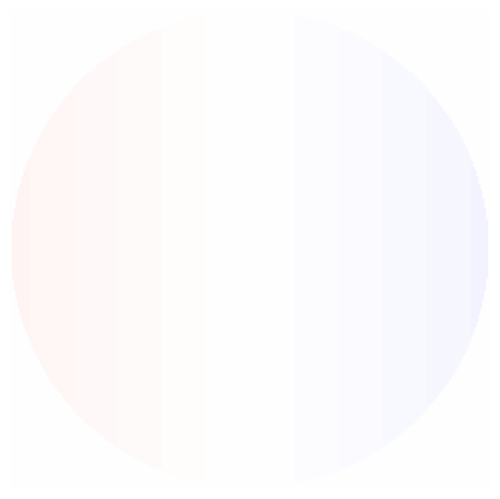

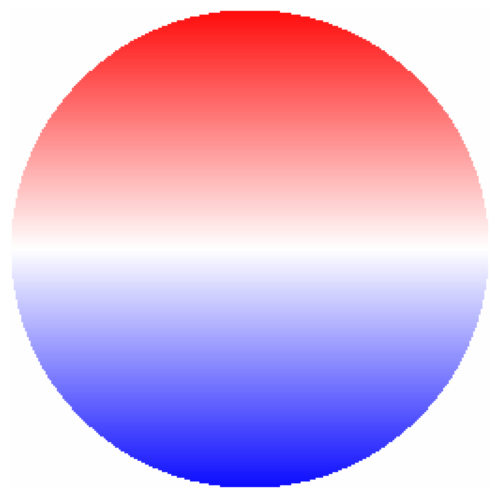

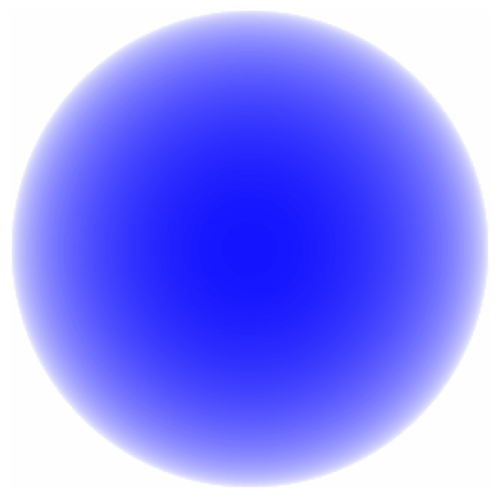

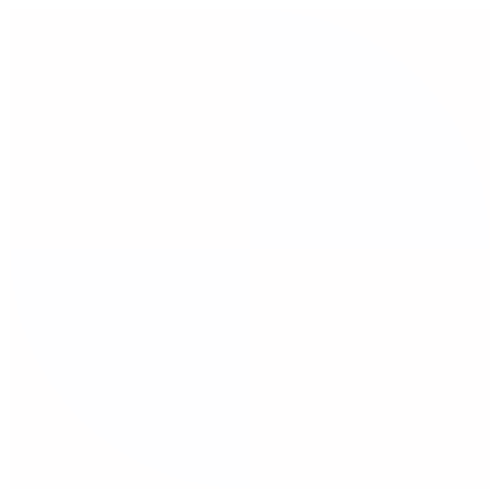

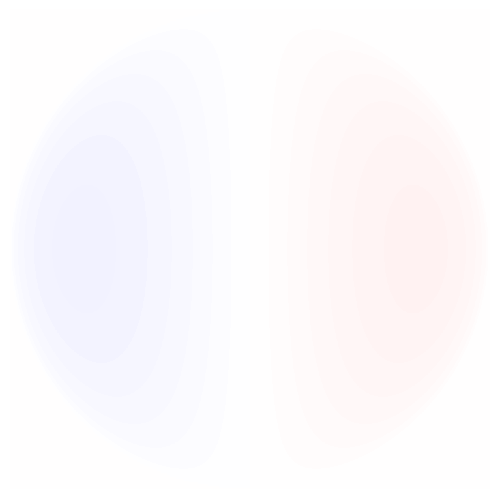

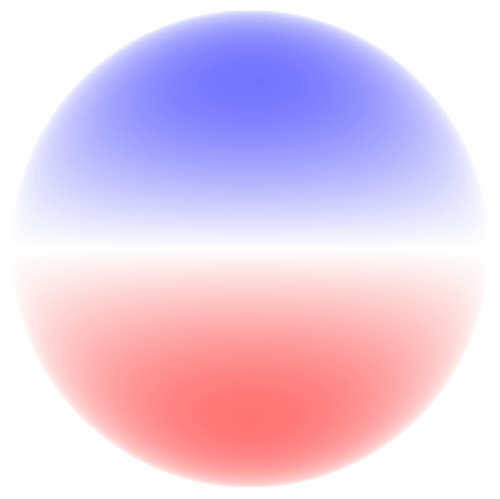

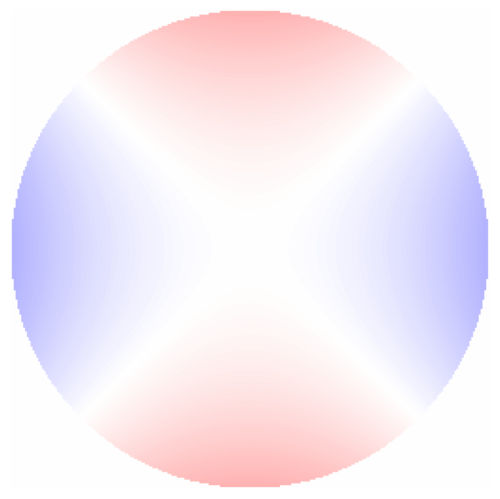

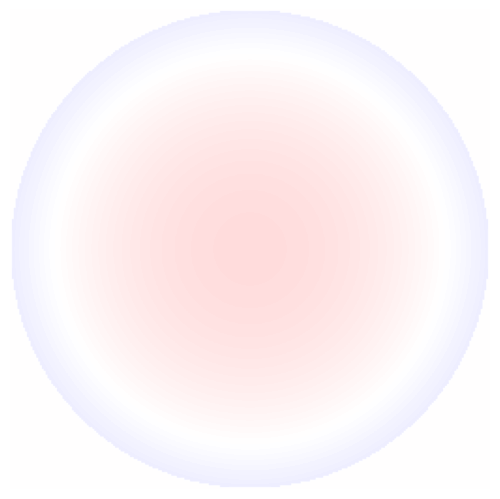

In [17]:
cmap = plt.cm.bwr
CAP_VALUE = 1
for image_id in [0]:
    image_columns = []
    # create first column for reference
    # create blank image size 256x256
    image_column = []
    sphere_image = Image.new('RGB', (256, 256))
    image_column.append(sphere_image)
    image_column.append(sphere_image)
    for channel in range(9):
        current_coeff = np.zeros((9,3))
        current_coeff[channel] = 1.0
        current_coeff = torch.tensor(current_coeff).float()
        sphere_image = drawSphere(current_coeff, is_back=False, white_bg=False).permute(1,2,0).numpy()
        sphere_image = np.dot(sphere_image[...,:3], [0.2989, 0.5870, 0.1140])
        fig, ax = plt.subplots(1,1, frameon=False, gridspec_kw={'wspace':0, 'hspace':0},squeeze=True)  # Create a figure and axes object
        ax.axis('off')  # Turn off the axis
        ax.set_frame_on(False)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        im = ax.imshow(sphere_image, cmap=cmap, vmin=-CAP_VALUE, vmax=CAP_VALUE)  # Create the image plot
        fig.canvas.draw()
        image_flat = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')  
        sphere_image = Image.fromarray(image_flat.reshape(*reversed(fig.canvas.get_width_height()), 3)).resize((256, 256))

        image_column.append(sphere_image)
    image_column = create_image_grid(image_column, rows=len(image_column), cols=1)
    image_columns.append(image_column)
    
    # create unage for other 6 direction
    for direction in DIRECTIONS:
        print('DIRECTION: ')
        gt_image = f"../../datasets/validation/angelica6axis_small05/images/{image_id:05d}/{direction}{image_id}.png"
        gt_image = Image.open(gt_image).resize((256, 256))
        sh_coeff = np.load(f"../../datasets/validation/angelica6axis_small05/light/{image_id:05d}/{direction}{image_id}_light.npy")
        image_output = [gt_image]
        # add all rendering image
        current_coeff = torch.tensor(sh_coeff).float()
        sphere_image = drawSphere(current_coeff, is_back=False, white_bg=False).permute(1,2,0).numpy()
        sphere_image = np.dot(sphere_image[...,:3], [0.2989, 0.5870, 0.1140])
        fig, ax = plt.subplots(1,1, frameon=False, gridspec_kw={'wspace':0, 'hspace':0},squeeze=True)  # Create a figure and axes object
        ax.axis('off')  # Turn off the axis
        ax.set_frame_on(False)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        im = ax.imshow(sphere_image, cmap=cmap, vmin=-0.2, vmax=0.2)  # Create the image plot
        fig.canvas.draw()
        image_flat = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')  
        sphere_image = Image.fromarray(image_flat.reshape(*reversed(fig.canvas.get_width_height()), 3)).resize((256, 256))
        image_output.append(sphere_image)
        for channel in range(9):
            current_coeff = np.zeros((9,3))
            current_coeff[channel] = sh_coeff[channel]
            current_coeff = torch.tensor(current_coeff).float()
            sphere_image = drawSphere(current_coeff, is_back=False, white_bg=False).permute(1,2,0).numpy()
            # combine to gray scale
            sphere_image = np.dot(sphere_image[...,:3], [0.2989, 0.5870, 0.1140])
            # TODO REMOVE
            # print min max 
            fig, ax = plt.subplots(1,1, frameon=False, gridspec_kw={'wspace':0, 'hspace':0},squeeze=True)  # Create a figure and axes object
            ax.axis('off')  # Turn off the axis
            ax.set_frame_on(False)
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            im = ax.imshow(sphere_image, cmap=cmap, vmin=-CAP_VALUE, vmax=CAP_VALUE)  # Create the image plot
            fig.canvas.draw()
            image_flat = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')  
            sphere_image = Image.fromarray(image_flat.reshape(*reversed(fig.canvas.get_width_height()), 3)).resize((256, 256))
            image_output.append(sphere_image)
        image_output = create_image_grid(image_output, rows=len(image_output), cols=1)
        image_columns.append(image_output)
        #display(image_output)
    image_columns = create_image_grid(image_columns, rows=1, cols=len(image_columns))
    image_columns.save(f"{image_id:05d}_light.png")
    display(image_columns)


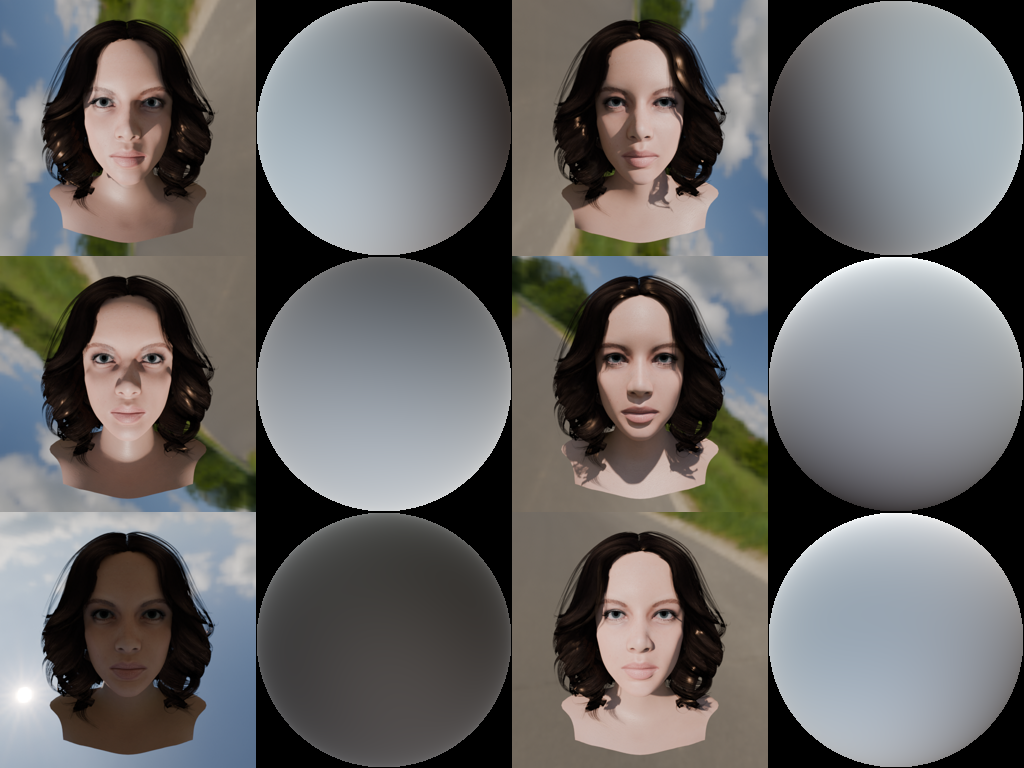

In [15]:

for image_id in [1]:
    image_output = []
    for direction in DIRECTIONS:
        gt_image = f"../../datasets/validation/angelica6axis_small05/images/{image_id:05d}/{direction}{image_id}.png"
        gt_image = Image.open(gt_image).resize((256, 256))
        sh_coeff = np.load(f"../../datasets/validation/angelica6axis_small05/light/{image_id:05d}/{direction}{image_id}_light.npy")
        sh_coeff = torch.tensor(sh_coeff).float()
        sphere_image = drawSphere(sh_coeff, is_back=False, white_bg=False).permute(1,2,0).numpy()
        sphere_image = Image.fromarray((sphere_image * 255).astype(np.uint8)).resize((256, 256))
        # concate 2 image 
        concate_image = Image.new('RGB', (gt_image.width + sphere_image.width, gt_image.height))
        concate_image.paste(gt_image, (0,0))
        concate_image.paste(sphere_image, (gt_image.width, 0))
        image_output.append(concate_image)
    image_output = create_image_grid(image_output, rows=3, cols=2)
    display(image_output)

# Only main axis 1,2,3

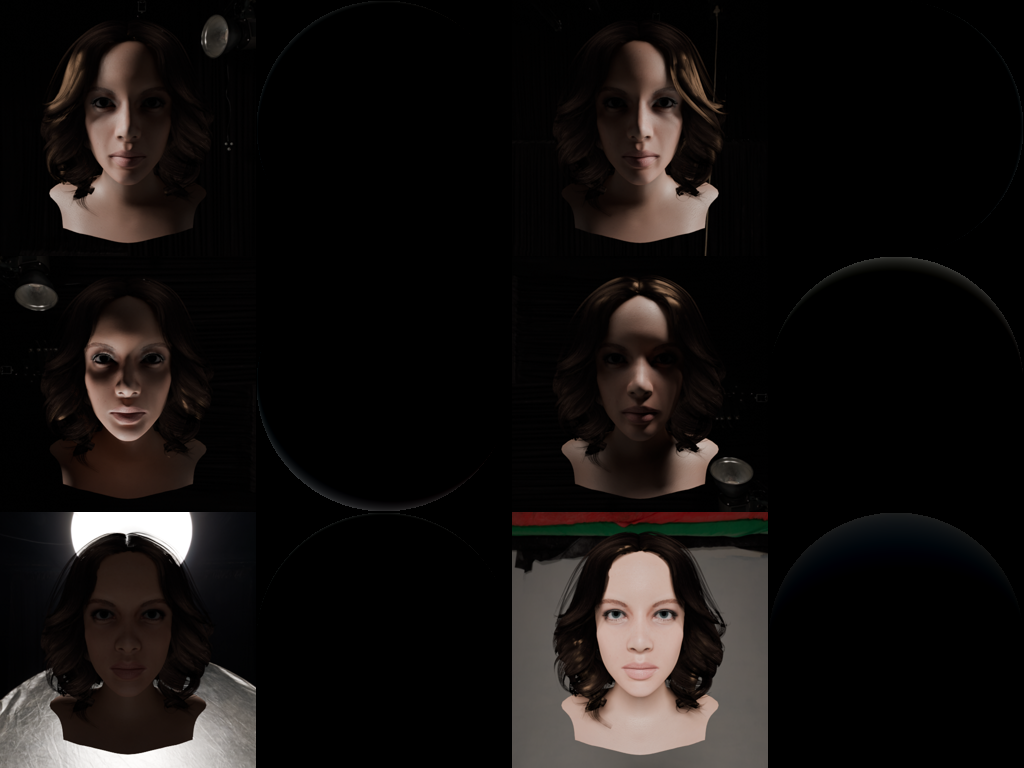

In [24]:

for image_id in [0]:
    image_output = []
    for direction in DIRECTIONS:
        gt_image = f"../../datasets/validation/angelica6axis_small05/images/{image_id:05d}/{direction}{image_id}.png"
        gt_image = Image.open(gt_image).resize((256, 256))
        sh_coeff = np.load(f"../../datasets/validation/angelica6axis_small05/light/{image_id:05d}/{direction}{image_id}_light.npy")
        sh_coeff[0,:] = 0
        sh_coeff[4:,:] = 0
        sh_coeff = torch.tensor(sh_coeff).float()
        sphere_image = drawSphere(sh_coeff, is_back=False, white_bg=False).permute(1,2,0).numpy()
        sphere_image = Image.fromarray((sphere_image * 255).astype(np.uint8)).resize((256, 256))
        # concate 2 image 
        concate_image = Image.new('RGB', (gt_image.width + sphere_image.width, gt_image.height))
        concate_image.paste(gt_image, (0,0))
        concate_image.paste(sphere_image, (gt_image.width, 0))
        image_output.append(concate_image)
    image_output = create_image_grid(image_output, rows=3, cols=2)
    display(image_output)

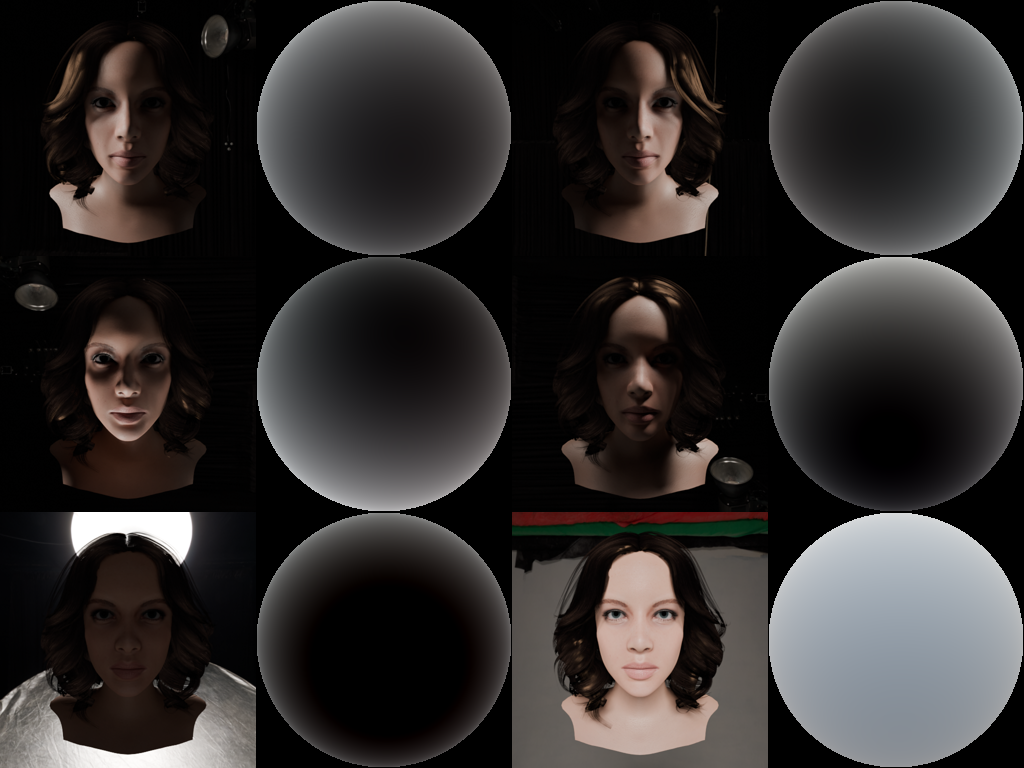

In [25]:

for image_id in [0]:
    image_output = []
    for direction in DIRECTIONS:
        gt_image = f"../../datasets/validation/angelica6axis_small05/images/{image_id:05d}/{direction}{image_id}.png"
        gt_image = Image.open(gt_image).resize((256, 256))
        sh_coeff = np.load(f"../../datasets/validation/angelica6axis_small05/light/{image_id:05d}/{direction}{image_id}_light.npy")
        #sh_coeff[0,:] = 0
        sh_coeff[4:,:] = 0
        sh_coeff = torch.tensor(sh_coeff).float()
        sphere_image = drawSphere(sh_coeff, is_back=False, white_bg=False).permute(1,2,0).numpy()
        sphere_image = Image.fromarray((sphere_image * 255).astype(np.uint8)).resize((256, 256))
        # concate 2 image 
        concate_image = Image.new('RGB', (gt_image.width + sphere_image.width, gt_image.height))
        concate_image.paste(gt_image, (0,0))
        concate_image.paste(sphere_image, (gt_image.width, 0))
        image_output.append(concate_image)
    image_output = create_image_grid(image_output, rows=3, cols=2)
    display(image_output)

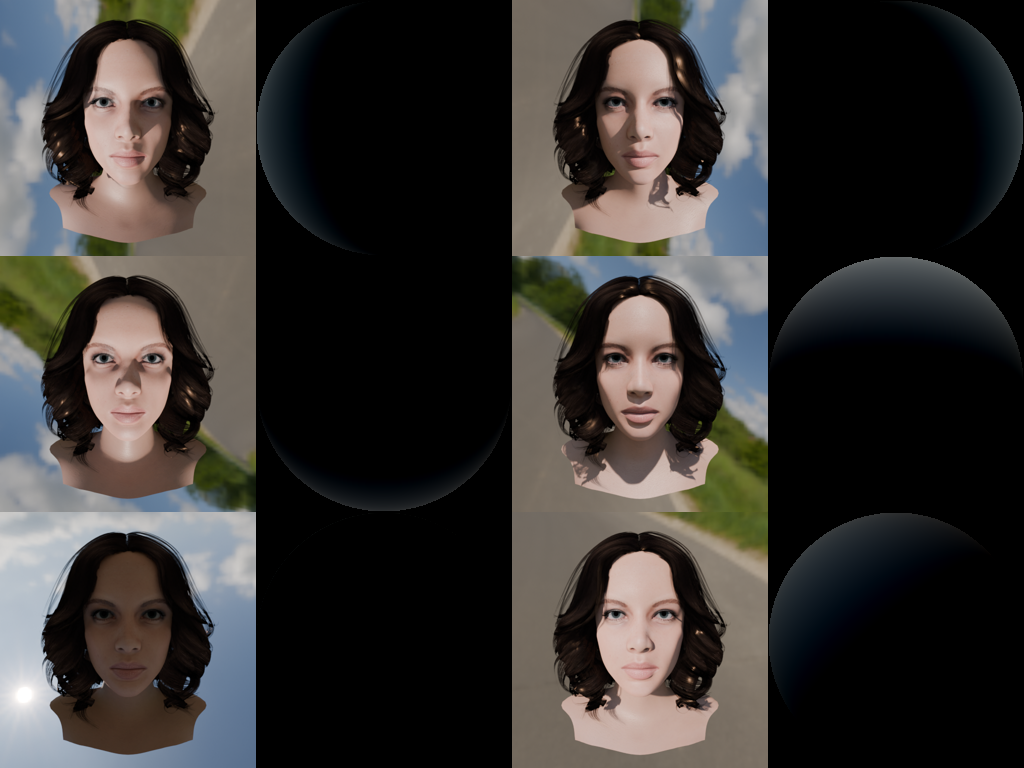

In [22]:

for image_id in [1]:
    image_output = []
    for direction in DIRECTIONS:
        gt_image = f"../../datasets/validation/angelica6axis_small05/images/{image_id:05d}/{direction}{image_id}.png"
        gt_image = Image.open(gt_image).resize((256, 256))
        sh_coeff = np.load(f"../../datasets/validation/angelica6axis_small05/light/{image_id:05d}/{direction}{image_id}_light.npy")
        sh_coeff[0,:] = 0
        sh_coeff[4:,:] = 0
        sh_coeff = torch.tensor(sh_coeff).float()
        sphere_image = drawSphere(sh_coeff, is_back=False, white_bg=False).permute(1,2,0).numpy()
        sphere_image = Image.fromarray((sphere_image * 255).astype(np.uint8)).resize((256, 256))
        # concate 2 image 
        concate_image = Image.new('RGB', (gt_image.width + sphere_image.width, gt_image.height))
        concate_image.paste(gt_image, (0,0))
        concate_image.paste(sphere_image, (gt_image.width, 0))
        image_output.append(concate_image)
    image_output = create_image_grid(image_output, rows=3, cols=2)
    display(image_output)

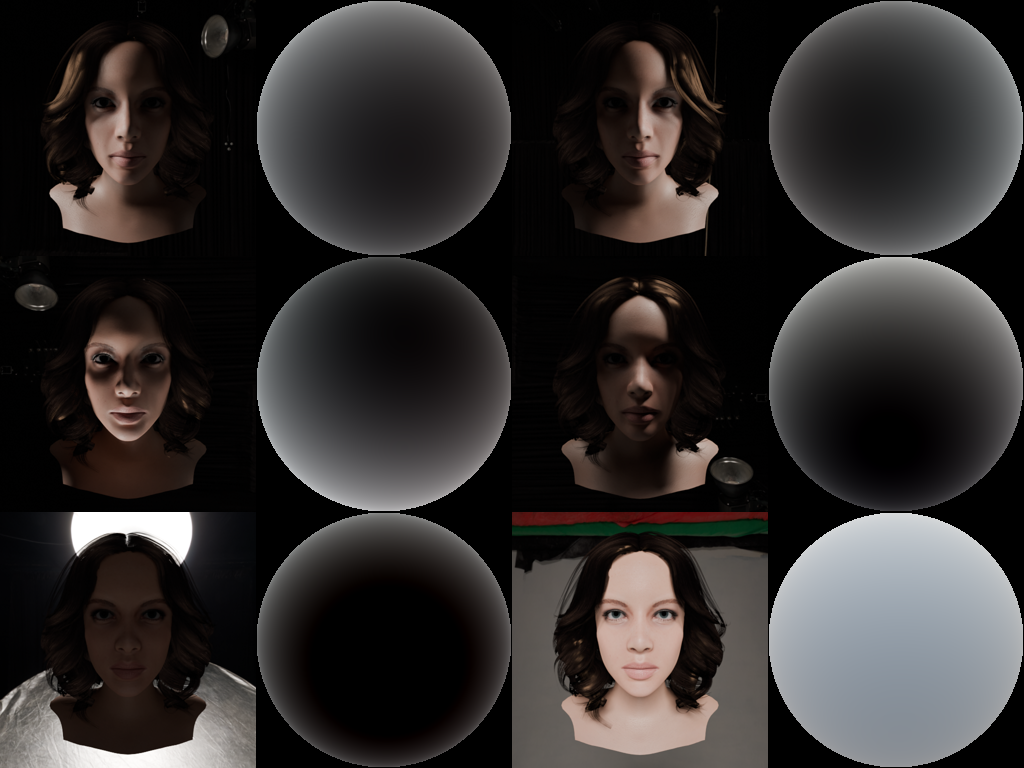

In [23]:

for image_id in [0]:
    image_output = []
    for direction in DIRECTIONS:
        gt_image = f"../../datasets/validation/angelica6axis_small05/images/{image_id:05d}/{direction}{image_id}.png"
        gt_image = Image.open(gt_image).resize((256, 256))
        sh_coeff = np.load(f"../../datasets/validation/angelica6axis_small05/light/{image_id:05d}/{direction}{image_id}_light.npy")
        #sh_coeff[0,:] = 0
        sh_coeff[4:,:] = 0
        sh_coeff = torch.tensor(sh_coeff).float()
        sphere_image = drawSphere(sh_coeff, is_back=False, white_bg=False).permute(1,2,0).numpy()
        sphere_image = Image.fromarray((sphere_image * 255).astype(np.uint8)).resize((256, 256))
        # concate 2 image 
        concate_image = Image.new('RGB', (gt_image.width + sphere_image.width, gt_image.height))
        concate_image.paste(gt_image, (0,0))
        concate_image.paste(sphere_image, (gt_image.width, 0))
        image_output.append(concate_image)
    image_output = create_image_grid(image_output, rows=3, cols=2)
    display(image_output)